In [19]:
import brainspace            #for plotting and calculating gradients
import numpy as np           #for working with arrays
import pandas as pd          #for working with data frames
import nilearn               #for plotting matrices
import seaborn               #for scatter and density plots
import brainstat
import scipy

In [20]:
from brainspace.datasets import load_conte69, load_parcellation, load_fsa5
from nilearn.datasets import fetch_atlas_schaefer_2018
from brainspace.utils.parcellation import map_to_labels
from brainspace.plotting import plot_hemispheres
from nilearn.connectome import ConnectivityMeasure
import nilearn.plotting
from brainspace.gradient import GradientMaps
import matplotlib.pyplot as plt
from brainstat.datasets import fetch_parcellation, fetch_template_surface
from scipy.io import loadmat

In [3]:
path= '/data/p_02667/Liisbeth/data/fc_matrices_glasser/Mean/'    # collecting the path, where all the matrices are saved

In [4]:
# Code written by Bianca Serio

import os

def fetch_all_sub_conn_matrices(path_conn_matrices):
    
    '''|
    
    Function that fetches the connectivity matrices of all subjects from path and stores them in a variable 
    
    Input:
    - path containing all the subject connectivity matrices
    
    Output (dictionary containing):
    - conn_matrices: np array contianing the connectivty matrices of all subjects (in the form of 1 np array per subject)
    - sub_list: list containing all the subject IDs
    
    
    '''
    
    # list that contains all the subject IDs of subjects with fc matrices
    sub_list = []

    # list that contains the fc matrices of all subjects in the form of 1 np array per subject
    conn_matrices = []

    # reads (lists) the content of the path containing the list of fc_matrices and stores the sorted contents in as a list in the variable list_fc_matrices
    list_conn_matrices = os.listdir(path_conn_matrices)
    list_conn_matrices.sort()

    for e in list_conn_matrices:
        if '.csv' in e:  # need to do this because there is a hidden files in the path_list_fc_matrices

            # add subject to the subjects' list
            sub_list.append(e.partition(".")[0])  # this partitions the subID.csv into a 3-tuple containing ('subID', '.', 'csv'), and I keep only the subID

            # reads csv file in the form of an array
            sub_matrix = np.genfromtxt(path_conn_matrices + e, delimiter=',')

            # add subject's matrix to the fc_matrices_400 list
            conn_matrices.append(sub_matrix)

    print(f'Connectivity matrices found in path {path_conn_matrices}: N = {len(sub_list)}')
    
    dict_output = {'conn_matrices': conn_matrices, 'sub_list': sub_list}
    
    return dict_output

In [5]:
# Code written by Bianca Serio

# fetch the functional connectivity matrices of all subjects (1014 subjects)
HCP_all = fetch_all_sub_conn_matrices(path)

# store the functional connectivity matrices and subject list in respecive variables
HCP_fc_matrices = HCP_all['conn_matrices']
HCP_sub_list = HCP_all['sub_list']


Connectivity matrices found in path /data/p_02667/Liisbeth/data/fc_matrices_glasser/Mean/: N = 1007


In [7]:
# Everything is included in brainspace

labeling= fetch_parcellation('fsaverage5', 'glasser', 360, data_dir = '/data/p_02667/Liisbeth/anaconda3/envs/actualdata/Glasser/')   # Importing the Schaefer 400 parcellation (for 64984 surf points)
atlas=  pd.read_csv('/data/p_02667/Liisbeth/anaconda3/envs/actualdata/Glasser/glasser360-master/glasser360NodeNames.txt', header =None)                 # Importing the labels/mapping of the parcellation
surf_lh, surf_rh=fetch_template_surface('fsaverage5', join = False, data_dir ='/data/p_02667/Liisbeth/anaconda3/envs/actualdata/Glasser/')                                # Loading the hemisphere surfaces with 32492 surf points per hemisphere
atlas = np.asarray(atlas)

In [8]:
mean_matrix = sum(HCP_fc_matrices)/len(HCP_fc_matrices)

In [ ]:
nilearn.plotting.plot_matrix(mean_matrix, figure=(30,30),labels = atlas, reorder=True)

In [9]:
gm_mean = GradientMaps(n_components=10, approach='dm', random_state=0, kernel = 'normalized_angle')  # creating the gradient model
# random state = 0 for replicable results

gm_mean.fit(mean_matrix)  # Fitting the gradient model to the mean connectivity matrix

GradientMaps(kernel='normalized_angle', random_state=0)

In [10]:
## Plotting the first 3 gradients

mask = labeling != 0     # Creating a boolean mask

grad_mean = [None]*3     # Creating an empty list for 3 gradients

for i in range(3):
    grad_mean[i]=map_to_labels(gm_mean.gradients_[:,i], labeling, mask = mask, fill=np.nan)  # Mapping gradient loadings to the parcellation
    


In [11]:
# Plotting the first 3 gradients and saving the image

plot = plot_hemispheres(surf_lh, surf_rh, 
                                array_name=grad_mean, 
                                embed_nb = True, 
                                size=(1200, 400), 
                                cmap='viridis_r', 
                                color_bar=True, 
                                label_text=['Gradient 1', 'Gradient 2', 'Gradient 3'], 
                                zoom=1.55,
                                screenshot = True,
                                filename = 'HCP_fcGlasser_DM_plotted_hemispheres_mean_gradients.png')

In [120]:
yeo_networks_glasser = scipy.io.loadmat( 'yeo_glasser360.mat' )
networks_yeo_numpy = pd.DataFrame(yeo_networks_glasser['yeo_glasser'])
networks_yeo_numpy = networks_yeo_numpy.replace(0,np.NaN)
networks_yeo_numpy = pd.DataFrame.to_numpy(networks_yeo_numpy.T)


In [140]:
yeo7_networks_array_labels = []

for i in networks_yeo_numpy.T:
    if i == 1:
        yeo7_networks_array_labels.append('visual')
    elif i == 2:
        yeo7_networks_array_labels.append('sensory motor')
    elif i == 3:
        yeo7_networks_array_labels.append('dorsal attention')
    elif i == 4:
        yeo7_networks_array_labels.append('ventral attention')
    elif i == 5:
        yeo7_networks_array_labels.append('limbic')
    elif i == 6:
        yeo7_networks_array_labels.append('fronto parietal')
    elif i == 7:
        yeo7_networks_array_labels.append('DMN')

        
yeo7_networks_array_labels = np.asarray(yeo7_networks_array_labels)

network_names = ["visual", "sensory motor", "dorsal attention", "ventral attention", "limbic", "fronto parietal", "DMN"]

TypeError: __init__() got an unexpected keyword argument 'reverse'

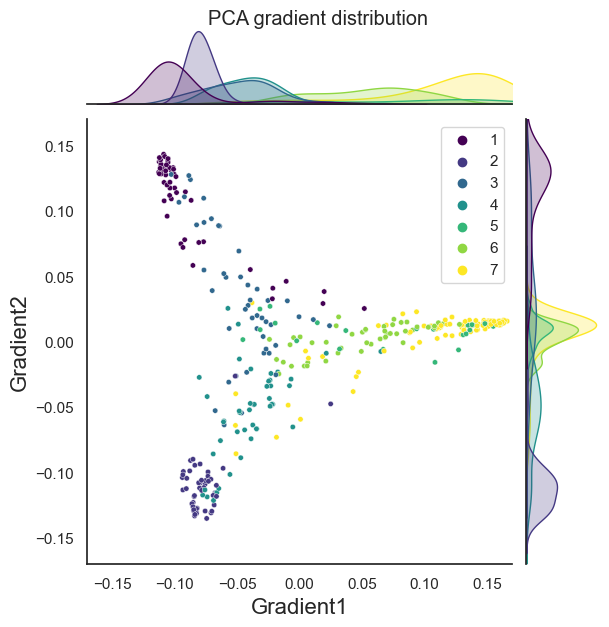

In [161]:
seaborn.set_theme(style='white')
cmap = 'viridis_r'
xlim=(-0.17,0.17)
ylim=(-0.17,0.17)
h=seaborn.jointplot(x=gm_mean.gradients_[:,0], y=gm_mean.gradients_[:,1], xlim = xlim, ylim = ylim, hue = networks_yeo_numpy[0],
                    palette = "viridis", s=15, dropna = True)



h.set_axis_labels('Gradient1', 'Gradient2', fontsize=16)

h.fig.suptitle("PCA gradient distribution", y=1)

h.fig.savefig('/data/p_02667/Liisbeth/anaconda3/envs/actualdata/PCA_gradient_distribution.png') 
plt.legend(title="Yeo 7 Networks (2011)", reverse = True, labels=network_names, bbox_to_anchor=(4, 1))


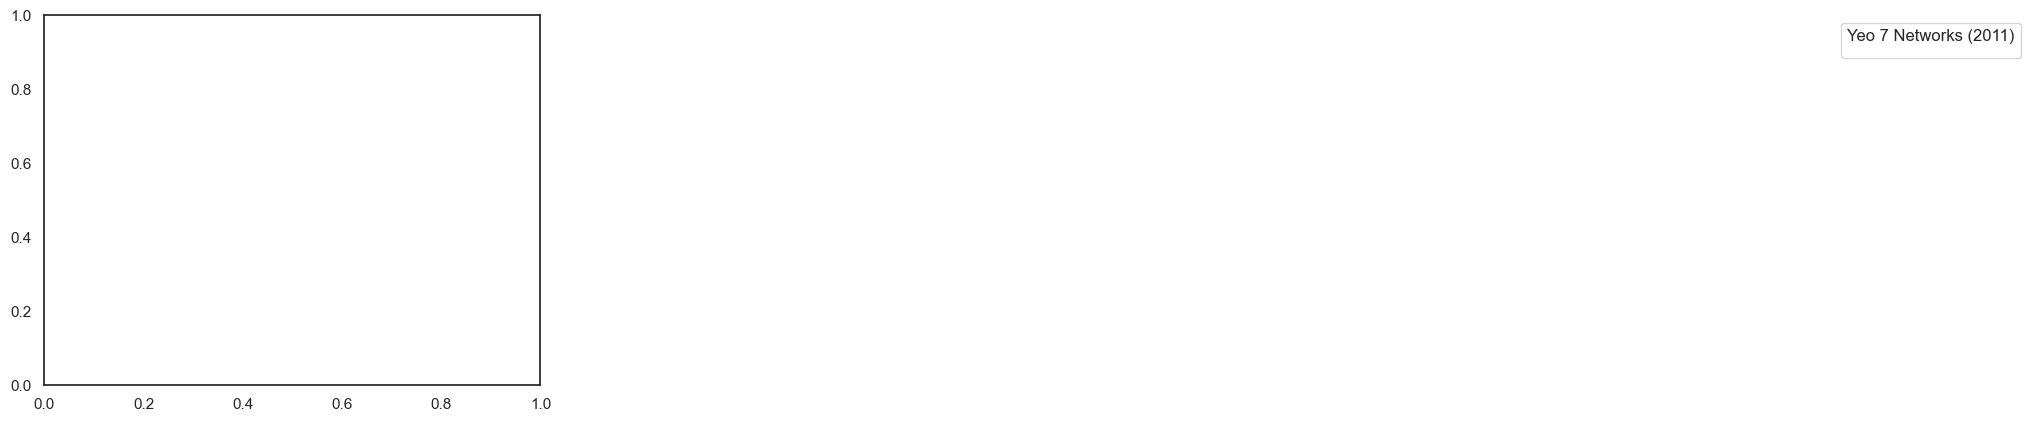

In [13]:
loadings = []*1007      # Creating an empty list, where the loadings for the first gradient for each participant will be appended

for i in range(len(HCP_fc_matrices)):
    gm = GradientMaps(approach = 'dm', random_state=0, kernel='normalized_angle', alignment='procrustes') #creating the alignment model
    gm.fit(HCP_fc_matrices[i], reference = gm_mean.gradients_) # fitting the alignment gradient model to each participants 400x400 connectivity matrix
    loadings.append(gm.aligned_[:,0]) #appending the loadings (1st gradient) for each parcel and each participant to the loadings list

In [ ]:
loadings_df_Glasser=pd.DataFrame(loadings) # converting the loadings list to a pandas dataframe
    
loadings_df_Glasser.to_csv('G1_loadings_Glasser.csv', index=False) # saving the df as a csv file for further analyses in R

In [14]:
sextq_values_DM = pd.read_csv('/data/p_02667/Liisbeth/anaconda3/envs/actualdata/Glasser/sex_contrasts_DM.csv', sep = ';', decimal=',')

sextq_numpy_DM = sextq_values_DM.to_numpy() # Converting the data frame to a numpy array

t_value_PCA = sextq_values_DM['t_value'].to_numpy()  #extracting the t values as a numpy array
q_value_PCA = sextq_values_DM['q_val'].to_numpy()    #extracting the q values (FDR corrected p values) as a numpy array

In [15]:
significant_parcels = []*360   # creating an empty list for 360 t values

for i in range(len(sextq_numpy_DM)):
    
    if sextq_numpy_DM[i, 2] < 0.05:     # if the corrected p-value (q-value) is <0.05 then...
              significant_parcels.append(sextq_numpy_DM[i, 0]) #t-value will be appended to the list.
    else:                                            # OTHERWISE
        significant_parcels.append(float('nan'))     # NaN will be appended
        
significant_parcels = np.array(significant_parcels)  # Converting the list to a numpy array
                                                     

In [16]:
mapped_significant = map_to_labels(significant_parcels, labeling, mask = mask, fill = np.nan) # mapping the t-values to the surface points

In [17]:
fdr_corr_tvals_plotted_hemispheres = plot_hemispheres(
        surf_lh, 
        surf_rh, 
        array_name = mapped_significant, 
        embed_nb = True, 
        size = (1400,200), 
        cmap = "bwr_r",  # bwr, _r stands for reversed; using it to match male-blue female-red 
        color_bar = True, 
        #color_range = color_range_t,
        nan_color = (0.7, 0.7, 0.7, 1),
        label_text = ["t-values"],
        zoom = 1.45,
        screenshot = True,
        filename = 'HCP_fcGlasser_DM_plotted_hemispheres_sex_contrast_t_val_fdr_corr.png')

In [18]:
fdr_corr_tvals_grad1 = plot_hemispheres(
        surf_lh, 
        surf_rh, 
        array_name = [grad_mean[0],mapped_significant], 
        embed_nb = True, 
        size = (1400,200), 
        cmap = ['viridis_r', "bwr_r"],  # bwr, _r stands for reversed; using it to match male-blue female-red 
        color_bar = True, 
        #color_range = color_range_t,
        nan_color = (0.7, 0.7, 0.7, 1),
        label_text = ['Mean gradient', "t-values"],
        zoom = 1.45,
        screenshot = True,
        filename = 'HCP_fcGlasser_DM_plotted_hemispheres_sex_contrast_t_val_fdr_gradient1.png')

In [67]:
len(yeo7_networks_array_labels)

356

In [31]:
len(gm_mean.gradients_[:,0])

(360,)

In [121]:
networks_yeo_numpy

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  2.,  3.,  3.,  2.,  1.,
         7.,  6.,  1.,  3.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  4.,  7.,
         7.,  7.,  6.,  7.,  7.,  7.,  7.,  7.,  7.,  2.,  4.,  4.,  2.,
         2.,  2.,  3.,  4.,  4.,  3.,  3.,  3.,  3.,  3.,  3.,  2.,  2.,
         2.,  2.,  2.,  2.,  4.,  6.,  4.,  4.,  7.,  7.,  6.,  7.,  7.,
         7.,  7.,  7.,  7.,  7.,  7.,  7.,  6.,  6.,  7.,  7.,  7.,  4.,
         6.,  3.,  6.,  6.,  6.,  6.,  6.,  6.,  7.,  5.,  7.,  5.,  6.,
         5.,  5.,  7.,  3.,  3.,  6.,  7.,  4.,  2.,  2.,  2.,  2.,  2.,
         4.,  4.,  2.,  4.,  4., nan,  6.,  7.,  4.,  4.,  4.,  3.,  3.,
         5.,  1., nan,  1.,  5.,  7.,  2.,  7.,  1.,  1.,  7.,  7.,  7.,
         5.,  7.,  7.,  7.,  5.,  3.,  3.,  3.,  7.,  3.,  3.,  1.,  3.,
         6.,  6.,  3.,  4.,  4.,  6.,  7.,  7.,  1.,  1.,  1.,  7.,  1.,
         3.,  1.,  1.,  1.,  7.,  7.,  1.,  5.,  7.,  5.,  4.,  2.,  4.,
         7.,  6.,  5.,  2.,  2.,  2.,  7.,  7.,  4.